In [7]:
%load_ext autoreload
%autoreload 2

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

In [157]:
from CustomTree.customTree import CustomDecisionTree
from CustomTree.decisionTreeToCustomTreeParser import sklearn_tree_to_custom_tree
# from CustomTree.graphicallyShowingTree import visualize_custom_tree #, plot_tree_partitions, plot_tree_partitions_2d_rectangles
from CustomTree.quadratic_constraint_optimization import gurobi_minimax, predict_with_minmax_model
from CustomTree.custom_tree_pruning import global_greedy_prune, global_greedy_prune_with_custom_cost, get_custom_cost_function

In [246]:
from Visualization.graphicallyShowingTree import visualize_custom_tree
from Visualization.partition_plot_matplotlib import plot_tree_partitions, plot_tree_partitions_2d_rectangles
from Visualization.partition_plot_matplotlib import plot_tree_partitions_3d_scatter, plot_tree_partitions_3d_cubes
from Visualization.partition_plot_plotly import plot_tree_partitions_plotly

In [197]:
from CustomTree.evaluationMethods import normalized_root_mean_square_error, mean_absolute_error

In [13]:

dataset_paths = {
    "Jet" : r'/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems With Non-Gaussian Noise via Formal Abstractions/Neural-Abstractions-V2/Dataset/jet/jet_10000/data_jet_10000.csv',
    # "Jet2" : r'/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems With Non-Gaussian Noise via Formal Abstractions/Neural-Abstractions-V2/Dataset/jet/jet_10000/data_jet_10000.csv',
}



# Jet System Experiment

In [214]:
jet_data_address = r'/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems With Non-Gaussian Noise via Formal Abstractions/Neural-Abstractions-V2/Dataset/jet/jet_10000/data_jet_10000.csv'
# jet_data_address = r'/Users/khalilulrehman/Academic/Phd Italy 2023_26/University of LAquila/Research Papers tasks/Benchmarks_Systems/Robust Control for Dynamical Systems With Non-Gaussian Noise via Formal Abstractions/Neural-Abstractions-V2/Dataset/steam/steam_10000/data_steam_10000.csv'

In [216]:
read_df = pd.read_csv(jet_data_address)
read_df.head()

,X1,X2,Y1,Y2
0,-0.566516,0.212083,-0.702585,-1.911632
1,0.494563,-0.467713,-0.059659,1.951401
2,-0.096054,1.006577,-1.119974,-1.294739
3,0.119205,-0.635532,0.513371,0.993149
4,0.256646,-1.095950,0.888697,1.865889


In [218]:


# X_read = read_df[["X1", "X2"]].values
# y_read = read_df[["Y1", "Y2"]].values
X_attribute_count = 2
Y_class_count = 2
X_read = read_df.iloc[:, :X_attribute_count].values
y_read = read_df.iloc[:, X_attribute_count:X_attribute_count + Y_class_count].values

X_train, X_test, y_train, y_test = train_test_split(
    X_read, y_read, test_size=0.3, random_state=42
)


dt_model_tree = DecisionTreeRegressor(
    max_depth=4, #8,          # intentionally deep
    min_samples_leaf=1,
    random_state=42
)

dt_model_tree.fit(X_train, y_train)



DecisionTreeRegressor(max_depth=4, random_state=42)

In [220]:

custom_tree = sklearn_tree_to_custom_tree(dt_model_tree, X_train)
print(f"Number of Nodes = {custom_tree.num_nodes()}\nNumber of Leaves = {custom_tree.num_leaves()}\nDepth of Tree = {custom_tree.compute_max_depth()}")



Number of Nodes = 31
Number of Leaves = 16
Depth of Tree = 4


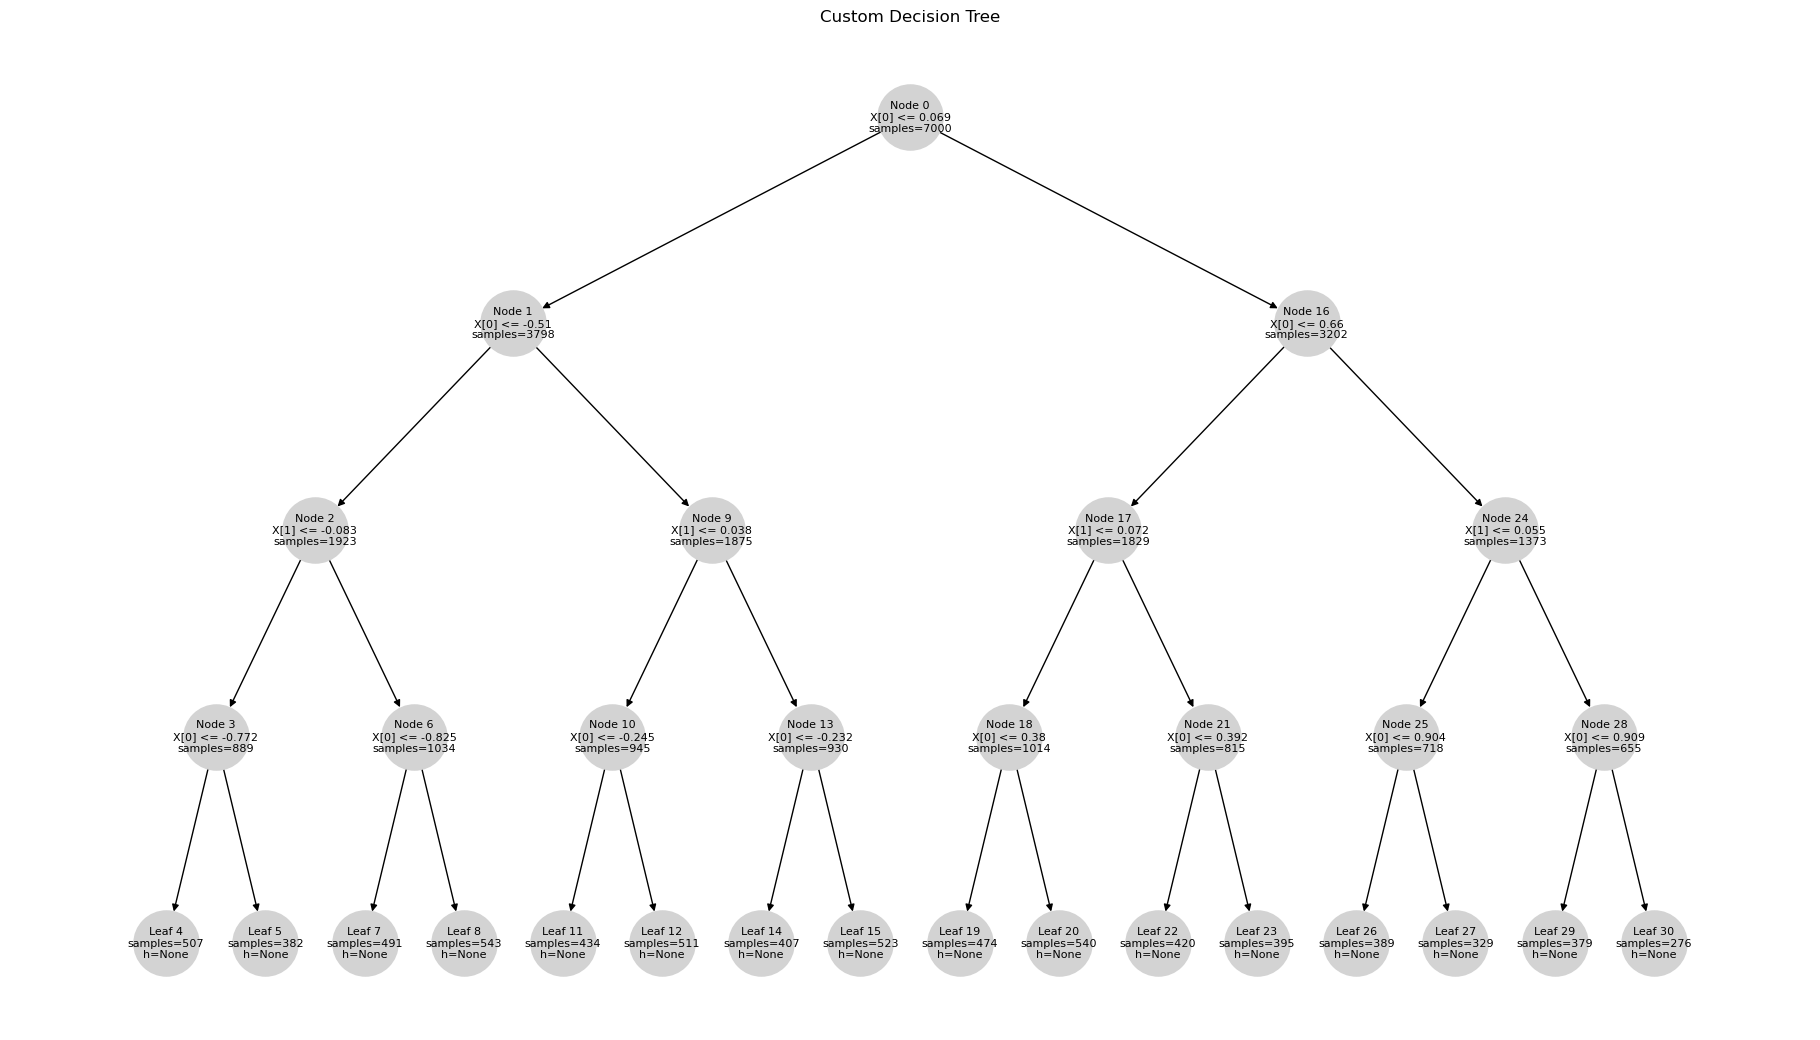

In [223]:
visualize_custom_tree(custom_tree)

In [225]:
# optimize original leaves
for leaf in custom_tree.get_leaves():
    M_val, m0_val, h_val = gurobi_minimax(
        X_train[leaf.sample_indices],
        y_train[leaf.sample_indices],
    )

    leaf.h = h_val
    leaf.M = M_val
    leaf.M_0 = m0_val


print("BEFORE")
print("nodes :", custom_tree.num_nodes())
print("leaves:", custom_tree.num_leaves())
print("depth :", custom_tree.compute_max_depth())





Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
Using Gurobi minimax solver...
BEFORE
nodes : 31
leaves: 16
depth : 4


In [31]:
test_h_leaves = custom_tree.get_leaves()
for test_leaf in test_h_leaves:
    print(test_leaf.h)

2.2395863934438095e-06
2.139045455423643e-05
6.398303828482817e-07
3.831344442731663e-05
6.654587217072976e-05
0.0002811544427487657
8.152837494436093e-05
0.0002410377740623342
0.0004964563372905506
0.0004962637630116564
0.0005632086559088031
0.0004061171392524297
0.00039026384867938384
0.00020694221548187426
0.0004062753221385704
0.00018375882138962172


In [2]:
global_greedy_prune(custom_tree, X_train, y_train, alpha=0.1, plot_tree_each_iteration=True)


NameError: name 'global_greedy_prune' is not defined

In [147]:
print("\nAFTER")
print("nodes :", custom_tree.num_nodes())
print("leaves:", custom_tree.num_leaves())
print("depth :", custom_tree.compute_max_depth())


AFTER
nodes : 31
leaves: 16
depth : 4


In [37]:
test_h_leaves = custom_tree.get_leaves()
for test_leaf in test_h_leaves:
    print(test_leaf.h)

0.01652994430504354
0.10029350851956845


In [4]:
alpha = 0.01
cost_fn = get_custom_cost_function(alpha, cost_type="average")

global_greedy_prune_with_custom_cost(custom_tree, X_train, y_train, cost_fn, plot_tree_each_iteration=True, alpha = alpha)

NameError: name 'get_custom_cost_function' is not defined

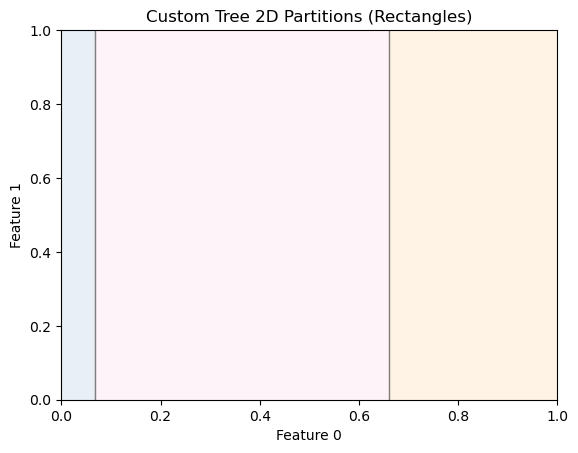

In [229]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
# plot_tree_partitions(custom_tree, X_train, ax=ax)
plot_tree_partitions_2d_rectangles(custom_tree, X_train, ax)
plt.show()
# plot_tree_partitions_plotly(custom_tree, X_train)


In [231]:
y_predict = predict_with_minmax_model(custom_tree=custom_tree, X=X_train)


In [233]:
normalized_root_mean_square_error(y_true=y_train, y_pred=y_predict)

0.005979588892573755

In [235]:
y_test_predict = predict_with_minmax_model(custom_tree=custom_tree, X=X_test)
normalized_root_mean_square_error(y_true=y_test, y_pred=y_test_predict)

0.006017207371774865

In [244]:
plot_tree_partitions_3d_scatter(custom_tree, X_train)

ValueError: This function only supports 3D inputs.

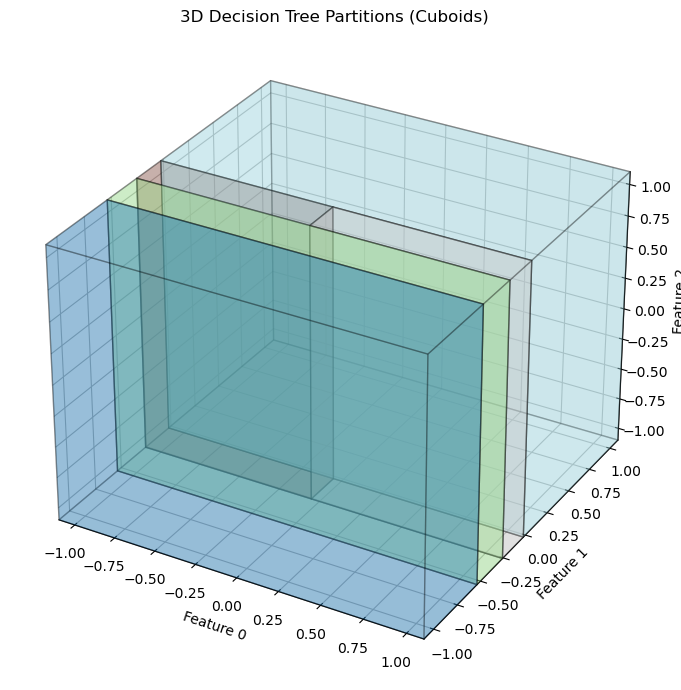

In [189]:
plot_tree_partitions_3d_cubes(custom_tree, X_train)
